In [193]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Preprocessing Dat

### Načtení dat, info a describe

In [128]:
data = pd.read_csv("data_titanic.csv", index_col="PassengerId")
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [130]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [131]:
data.describe(include="object")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Chybějící hodnoty a úprava slopců

In [132]:
# golobální průměr věk
data["Age"].mean()

29.69911764705882

In [133]:
# jaký věk doplnit? -> místo např. globálního průměru vezmeme medián podle třídy pasažéra, u kterého chybí hodnota -> přesnější
tabulka_dopln_vek = data[["Age", "Pclass"]].groupby("Pclass").median()
tabulka_dopln_vek

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [134]:
# řádek po řádku, pokud chybí věk -> je nan, tak najdi jeho třídu a podívej se do tabulky s mediány a doplň, pokud ne nech tam původní věk
data["Age"] = data.apply(lambda row: tabulka_dopln_vek.loc[row["Pclass"]].values[0] if np.isnan(row["Age"]) else row["Age"], axis=1)

In [135]:
# pokud měl sourozence nebo partnera na palubě -> 1, pokud ne tak 0
data["SibSp"] = data["SibSp"].apply(lambda x: 0 if x == 0 else 1)

In [136]:
# pokud měl dítě nebo rodiče na palubě -> 1, pokud ne tak 0
data["Parch"] = data["Parch"].apply(lambda x: 0 if x == 0 else 1)

In [137]:
# Skoro samé unikátní hodnoty, navíc u Cabin drtivá většina chybí
sloupce_ke_smazani = ["Name", "Ticket", "Cabin"]
data = data.drop(columns=sloupce_ke_smazani)

In [138]:
nejcastejsi_pristav = data["Embarked"].value_counts().idxmax()
data["Embarked"] = data["Embarked"].fillna(nejcastejsi_pristav)

### Úprava datovýách typů

In [139]:
# přetypuj u věku z float na int -> věk se udává v celých číslech
data["Age"] = data["Age"].astype(int)

In [140]:
# enkódování -> ordinal -> pro každou unikátní hodnotu přiřadíme číslo
pohlavi_na_text = {"female": 0, "male": 1}
data["Sex"] = data["Sex"].apply(lambda x: pohlavi_na_text[x])

In [141]:
pristavy = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
data["Embarked"] = data["Embarked"].apply(lambda x: pristavy[x])

In [142]:
data["Embarked"].value_counts()

Embarked
Southampton    646
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [143]:
embarked_table = pd.get_dummies(data["Embarked"], drop_first=True).astype(int)
embarked_table

,Queenstown,Southampton
PassengerId,,
1,0,1
2,0,0
3,0,1
4,0,1
5,0,1
...,...,...
887,0,1
888,0,1
889,0,1


In [144]:
data = data.join(embarked_table).drop(columns=["Embarked"])

### Škálování hodnot

In [147]:
ss_scaler = MinMaxScaler()
data = pd.DataFrame(ss_scaler.fit_transform(data), columns=data.columns)

### Korelace a výběr featur

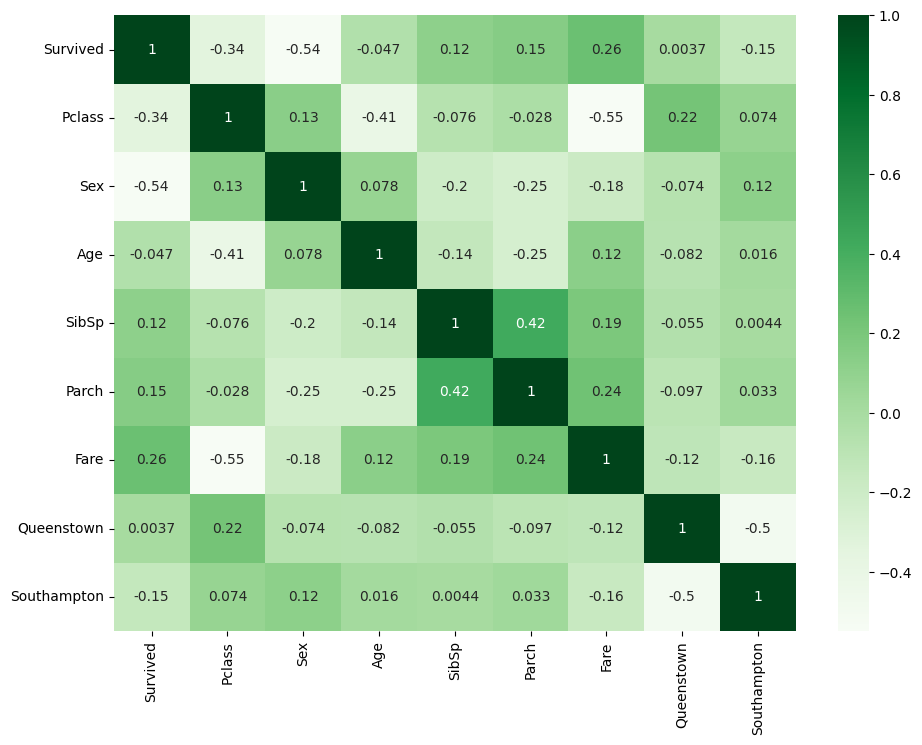

In [148]:
corr = data.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [149]:
# treshold, od kdy bereme sloupec jako relevantní prediktor -> vezmeme pro trénink
corr_treshold = 0.2
# vygenereovat list True -> splňuje nebo False -> nesplňuje
splnuje_treshold = list(abs(corr.iloc[0]) >= corr_treshold)
# sloupce tabulky
sloupce = list(data.columns)
# vyber mi jenom slopupce splňující treshold
sloupce_nad_treshold = [sloupce[i] for i in range(len(sloupce)) if splnuje_treshold[i]]

In [152]:
REDUKOVAT = True
# přepínač, jestli zredukovat sloupce podle korelace nebo ne
if REDUKOVAT:
    data = data[sloupce_nad_treshold]

### Rozdělení na trénovací a testovací data

In [ ]:
# rozdělení target a a featury
y = data["Survived"]
X = data.drop(columns=["Survived"])

In [ ]:
# díky stratify rozděl v rámci každé tříty 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Modelování

### Lazy predict -> vyzkoušet ve smyčcevšechny sklearn modely se základním nastavením a jednoduchým preprocessingem

In [166]:
lc = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lc.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:02<00:00, 10.47it/s]

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.80,0.78,0.78,0.80,0.04
BaggingClassifier,0.80,0.78,0.78,0.80,0.10
RandomForestClassifier,0.79,0.77,0.77,0.79,0.43
NuSVC,0.79,0.77,0.77,0.79,0.07
ExtraTreeClassifier,0.79,0.77,0.77,0.79,0.05
GaussianNB,0.78,0.77,0.77,0.78,0.05
AdaBoostClassifier,0.78,0.77,0.77,0.78,0.30
NearestCentroid,0.77,0.77,0.77,0.77,0.04
ExtraTreesClassifier,0.79,0.76,0.76,0.79,0.61


### Vybrali jsme model podle Lazy Predict -> hledání optimálních parametrů pomocí grid search

In [ ]:
# knn podle lazy predict vypadá slibně
knn = KNeighborsClassifier()
# parametry, podle kterých budu hledat optimální nastavení modelu
parametry = {'metric':('minkowski', 'manhattan', 'cosine'), 'weights':('uniform', 'distance'), 'n_neighbors':[3, 5, 7, 9]}
# inicializace grid search -> optimalizace - hledání nejlepší kombinace pro daný model a parametry
gs = GridSearchCV(knn, parametry)

In [ ]:
# provedení hodně tréninků pomocí k-fold a najití nejlepší kombinace parametrů
gs.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ('minkowski', 'manhattan', 'cosine'),
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ('uniform', 'distance')})

In [ ]:
# vítězné parametry
gs.best_params_

{'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}

In [ ]:
# model s nejlepšími parametry
best_knn = gs.best_estimator_

In [ ]:
# predikce pomocí nejlepšího modelu
y_best_knn = best_knn.predict(X_test)

### Vyhodnocení na test datech

In [ ]:
print(classification_report(y_test, y_best_knn))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       110
         1.0       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



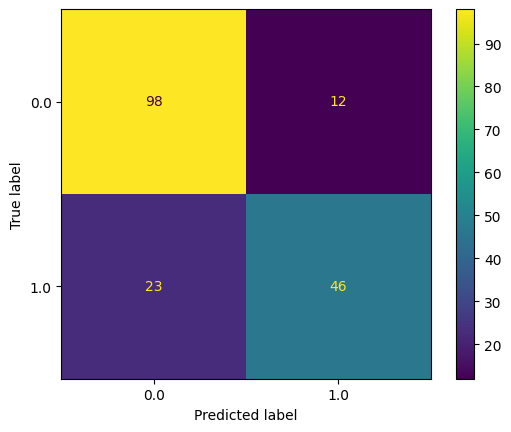

In [ ]:
# Confusion matice
cm = confusion_matrix(y_test, y_best_knn, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_knn.classes_)
disp.plot()
plt.show()

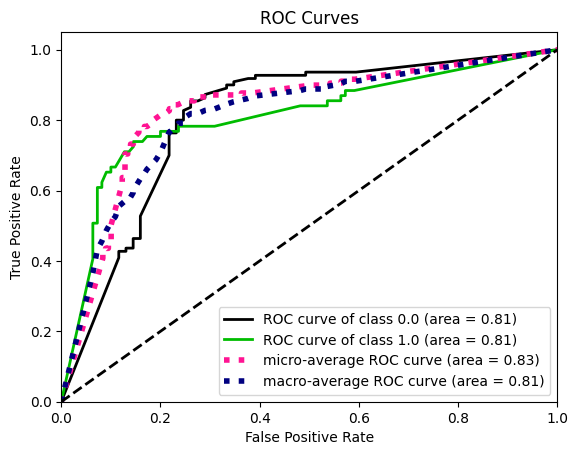

In [ ]:
# výstup modelu jako číslo -> ne třída (.predict_proba vs .predict)
y_best_knn_proba = best_knn.predict_proba(X_test)

# nakreslit ROC křivku
skplt.metrics.plot_roc_curve(y_test, y_best_knn_proba)
plt.show()